# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


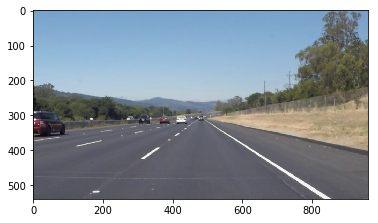

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

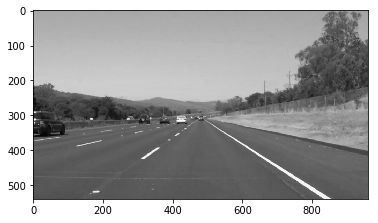

In [3]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY),cmap = "gray")

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

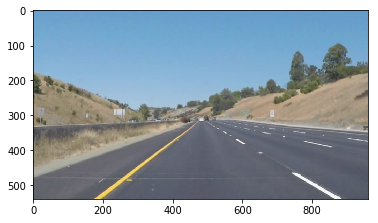

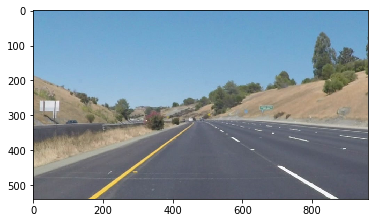

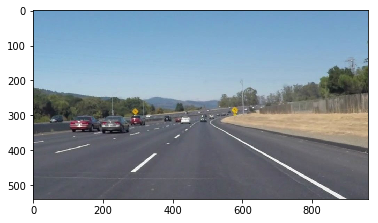

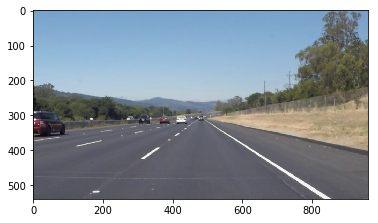

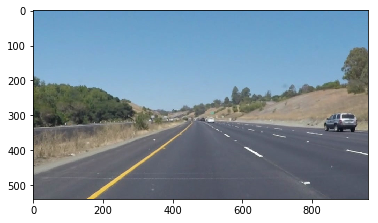

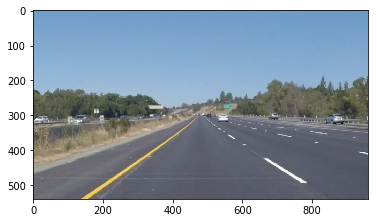

In [5]:
import os
test_pics = os.listdir("test_images/")

for i in test_pics:
    i = 'test_images/' + i
    image = mpimg.imread(i)
    plt.imshow(image)
    plt.show()

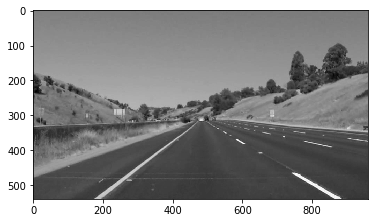

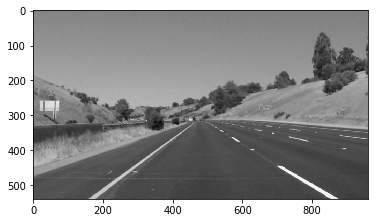

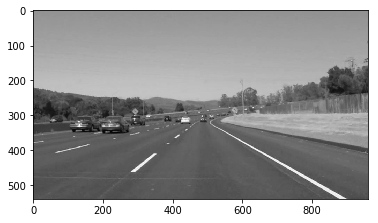

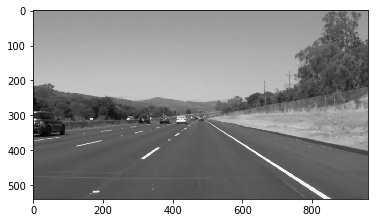

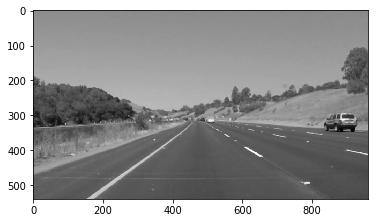

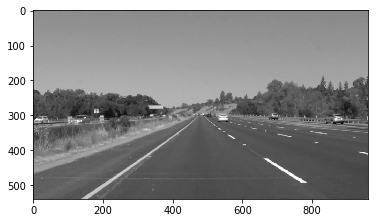

In [6]:

for i in test_pics:
    i = 'test_images/' + i
    image = mpimg.imread(i)
    gray=grayscale(image)
    plt.imshow(gray,cmap = "gray")
    plt.show()


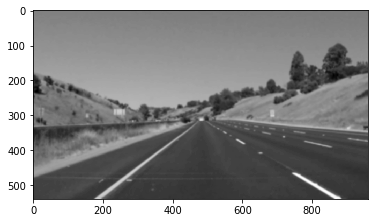

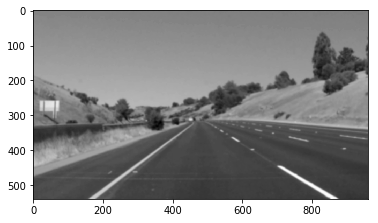

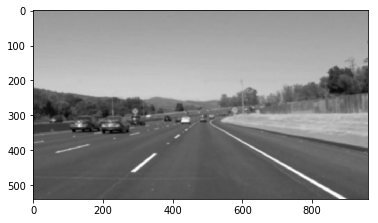

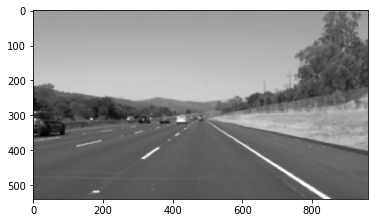

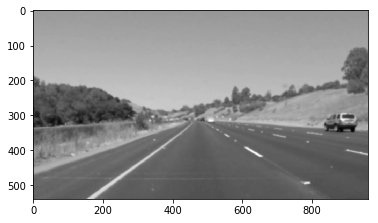

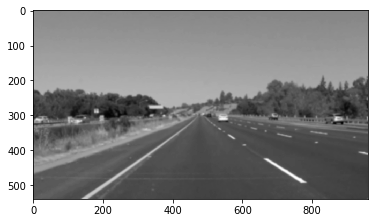

In [7]:
kernel_size = 9

for i in test_pics:
    i = 'test_images/' + i
    image = mpimg.imread(i)
    gray=grayscale(image)
    Blur_gray = gaussian_blur(gray, kernel_size)
    plt.imshow(Blur_gray,cmap = "gray")
    plt.show()

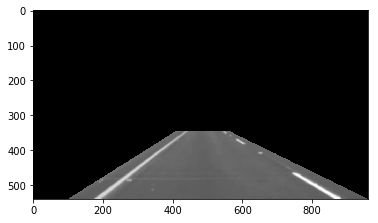

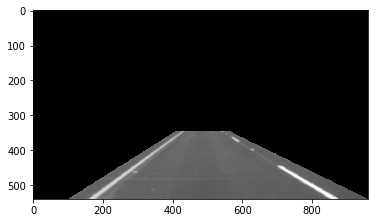

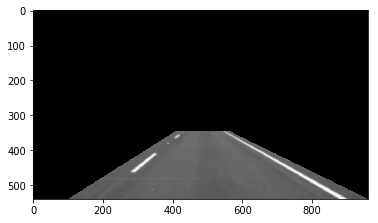

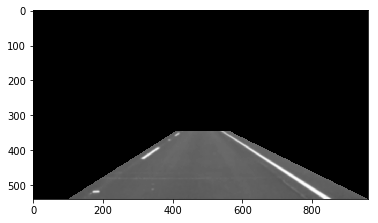

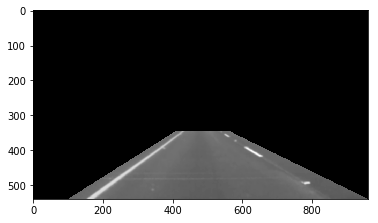

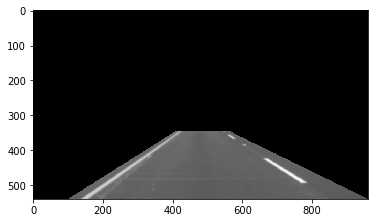

In [8]:
low_threshold = 70
high_threshold = 250
for i in test_pics:
    i = 'test_images/' + i
    image = mpimg.imread(i)
    imshape=image.shape
    
    gray=grayscale(image)
    Blur_gray = gaussian_blur(gray, 9)
    
    vertices =  np.array([[(100,imshape[0]),(410, 345), (560, 345), (imshape[1],imshape[0])]], dtype=np.int32) 
    mask =region_of_interest(Blur_gray, vertices)
    cannyOut = canny(Blur_gray, low_threshold, high_threshold)
    plt.imshow(mask,cmap="gray")
    plt.show()


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [9]:
def Find_lines(img):
    left_lines = []
    left_slopes = []
    right_lines = []
    right_slopes = []
    gray = grayscale(img)
    kernel_size = 9
    blur_gray = gaussian_blur(gray, kernel_size)
    low_threshold = 90
    high_threshold = 190
    edges = canny(blur_gray, low_threshold, high_threshold) 
    imshape = image.shape
    vertices =  np.array([[(100,imshape[0]),(410, 345), (560, 345), (imshape[1],imshape[0])]], dtype=np.int32) 
    
    masked_edges = region_of_interest(edges, vertices)
    rho = 5 # distance resolution in pixels of the Hough grid
    theta = np.pi/90 # angular resolution in radians of the Hough grid
    threshold = 40     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 25 #minimum number of pixels making up a line
    max_line_gap = 28    # maximum gap in pixels between connectable line segments
    line_image = np.copy(img)*0 # creating a blank to draw lines on
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            if slope < 0:
                left_lines.append(line)
                left_slopes.append(slope)
            else:
                right_lines.append(line)
                right_slopes.append(slope)
    
    avg_left_pos = [sum(col)/len(col) for col in zip(*left_lines)] 
    avg_right_pos = [sum(col)/len(col) for col in zip(*right_lines)]
    avg_left_slope = np.mean(reject_outliers(left_slopes))
    print(avg_left_slope)
    avg_right_slope = np.mean(reject_outliers(right_slopes))
    print(avg_right_slope)
    avg_left_line = []
    for x1,y1,x2,y2 in avg_left_pos:
        x = int(np.mean([x1, x2])) 
        y = int(np.mean([y1, y2]))
        slope = avg_left_slope
        b = -(slope * x) + y # line equation 
        avg_left_line = [int((325-b)/slope), 325, int((520-b)/slope), 520] 
    
    avg_right_line = []
    for x1,y1,x2,y2 in avg_right_pos:
        x = int(np.mean([x1, x2]))
        y = int(np.mean([y1, y2]))
        slope = avg_right_slope
        b = -(slope * x) + y
        avg_right_line = [int((325-b)/slope), 325, int((520-b)/slope), 520]
    lines = [[avg_left_line], [avg_right_line]]
    draw_lines(line_image, lines)
    line_edges = weighted_img(line_image, img)
    return line_edges



In [10]:
def reject_outliers(slopes, m = 2):
    for slope in slopes:
        if abs(slope - np.mean(slopes)) > (m * np.std(slopes)):
            slopes.remove(slope)
    return slopes

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [12]:
def process_image(image):
    result = Find_lines(image)
    return result
        # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    

Let's try the one with the solid white lane on the right first ...

In [13]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

0.619956071107
-0.761421137467
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  2%|▏         | 4/222 [00:00<00:06, 35.64it/s]

0.619956071107
-0.761421137467
0.616232077218
-0.746842660491
0.591109726275
-0.742700082186
0.624530652404
-0.748270340989
0.608288410454
-0.730238511489
0.62230015836
-0.712179589043
0.626989809536
-0.730102941176


  4%|▎         | 8/222 [00:00<00:05, 36.82it/s]

0.556185585382
-0.741942754113


  5%|▌         | 12/222 [00:00<00:05, 37.70it/s]

0.59911477838
-0.722739771634
0.618756492097
-0.699968711073
0.703568223337
-0.704475647871
0.633255007885
-0.721773952612
0.618975895188
-0.727946267977
0.653557502351
-0.749304871447
0.64855804741
-0.691779866061
0.628156094361

  7%|▋         | 16/222 [00:00<00:05, 38.09it/s]


-0.67842937582
0.657849283827

  9%|▉         | 20/222 [00:00<00:05, 38.57it/s]


-0.679487179487
0.676220973126
-0.678912442396
0.651086125966
-0.712675138482
0.632106566768
-0.708692936634
0.656487468888
-0.70134681508
0.639155195253
-0.700675239793
0.638798848921
-0.702107052498
0.626288467665
-0.719537480064


 13%|█▎        | 29/222 [00:00<00:04, 39.39it/s]

0.646543292561
-0.707571679528
0.633070491933
-0.666423691796
0.644111671353
-0.724778599144
0.662582045878
-0.721702154775
0.661690076149
-0.701818181818
0.65748629769
-0.701282612662
0.655795083114
-0.720331073779
0.63149055248
-0.724380530263
0.643346678924
-0.722648566045


 17%|█▋        | 38/222 [00:00<00:04, 39.15it/s]

0.64841547544
-0.75045613117
0.644216428565
-0.683344762278
0.660081168485
-0.73224140728
0.634499925573
-0.719028075171
0.667195529075
-0.73703509665
0.655457367099
-0.729856498714
0.653339831349
-0.707581698633
0.649568008426
-0.690476190476


 19%|█▉        | 42/222 [00:01<00:04, 37.94it/s]

0.669281453513
-0.694091710758
0.672037651924
-0.726116071429


 21%|██        | 46/222 [00:01<00:08, 20.07it/s]

0.649524379862
-0.718802205567
0.659908961387
-0.721658820148
0.620210531145
-0.739413593482


 22%|██▏       | 49/222 [00:01<00:09, 18.09it/s]

0.65479060609
-0.742656310492
0.646974069603
-0.71225528554
0.646667125889
-0.724068475305
0.620117824805

 23%|██▎       | 52/222 [00:01<00:10, 16.50it/s]


-0.722443244514
0.638542228918
-0.73524913715
0.645959376898
-0.719185099952


 25%|██▍       | 55/222 [00:02<00:10, 15.34it/s]

0.649927140833
-0.700426929392
0.622964476779
-0.694186560566
0.610767195539
-0.694295707653


 26%|██▌       | 57/222 [00:02<00:10, 15.01it/s]

0.659666265348
-0.692277557603
0.639599229411
-0.68112407211
0.668609193196
-0.651023255261


 27%|██▋       | 61/222 [00:02<00:11, 14.54it/s]

0.634485757147
-0.691614002963
0.631076757644
-0.690802726743
0.640959262687
-0.702394369465
0.650625511585

 28%|██▊       | 63/222 [00:02<00:11, 13.96it/s]


-0.71775977094
0.63540466348
-0.69121239607
0.662196282994
-0.677933780396


 30%|███       | 67/222 [00:03<00:10, 14.21it/s]

0.655322113323
-0.693076923077
0.647384010954
-0.635941644562
0.638067942584
-0.691963044256


 31%|███       | 69/222 [00:03<00:10, 14.23it/s]

0.659560325794
-0.692339192339
0.625527737283
-0.692902896777
0.656204830714
-0.704284277814
0.654797979798
-0.68093499116


 33%|███▎      | 73/222 [00:03<00:10, 14.47it/s]

0.655295459724
-0.658679467451
0.677639075443
-0.66832104447
0.657876653959
-0.657661300067


 35%|███▍      | 77/222 [00:03<00:10, 13.93it/s]

0.648266248071
-0.662756673905
0.670943964367
-0.671637431173
0.637226649568
-0.680591439341


 36%|███▌      | 79/222 [00:03<00:10, 14.01it/s]

0.672343524098
-0.711254262978
0.655401177095
-0.669490740741
0.644071169024
-0.668101248597
0.64580885587
-0.658333333333


 37%|███▋      | 83/222 [00:04<00:09, 14.40it/s]

0.666085713412
-0.657067196293
0.676863549242
-0.657104586955
0.692445976212
-0.639857881137
0.706919607017
-0.653825995807


 39%|███▉      | 87/222 [00:04<00:09, 14.15it/s]

0.686499579634
-0.626879482957
0.683960680376
-0.628233566826
0.691319031448
-0.652815559959
0.666805109139
-0.660584589502


 41%|████      | 91/222 [00:04<00:09, 14.39it/s]

0.65660403295
-0.661823361823
0.709361268323
-0.64729601518
0.750089081333
-0.641870763822


 43%|████▎     | 95/222 [00:04<00:08, 14.64it/s]

0.690109247678
-0.650488709134
0.728116818702
-0.63749028749
0.664954829771
-0.612780554641
0.691870543118
-0.619838524655


 45%|████▍     | 99/222 [00:05<00:08, 14.38it/s]

0.668688681372
-0.645668881757
0.727393383589
-0.651106286446
0.688085948278
-0.658810846015
0.714691005959
-0.64253324932


 46%|████▋     | 103/222 [00:05<00:08, 14.10it/s]

0.71449174047
-0.626643415751
0.75478929725
-0.642553062093
0.715453745601
-0.646854575163


 47%|████▋     | 105/222 [00:05<00:08, 14.22it/s]

0.700020108534
-0.672916666667
0.680601624348
-0.663831711474
0.726939902132
-0.641025641026
0.67311619406

 49%|████▉     | 109/222 [00:05<00:07, 14.52it/s]


-0.680474095797
0.68425529279
-0.69337406015
0.697691507883
-0.696015696737
0.689634945302
-0.704141849068


 51%|█████     | 113/222 [00:06<00:07, 14.45it/s]

0.678917247402
-0.713836814769
0.679917608494
-0.69231504726
0.666297073283
-0.674429137051
0.67304179253
-0.703171908551


 53%|█████▎    | 117/222 [00:06<00:07, 14.61it/s]

0.662993590208
-0.666778673835
0.666549636161
-0.681939752252
0.682692095525
-0.690819056439
0.666514888552
-0.682420019895


 55%|█████▍    | 121/222 [00:06<00:06, 14.44it/s]

0.656762411591
-0.702741702742
0.639044680807
-0.668359542822
0.676383981299
-0.686263198751
0.63402106394
-0.663183142052


 56%|█████▋    | 125/222 [00:07<00:06, 14.61it/s]

0.62232992398
-0.687936296027
0.644260847368
-0.663465210232
0.64996597193
-0.67627097655
0.665874098047
-0.693403561955


 58%|█████▊    | 129/222 [00:07<00:06, 13.96it/s]

0.650305275035
-0.690685336169
0.647440944585
-0.692284136671
0.631249293657
-0.698753702653


 59%|█████▉    | 131/222 [00:07<00:06, 14.17it/s]

0.637773067159
-0.69595039019
0.62177255736
-0.670805275008
0.636905087447
-0.691800233087


 60%|█████▉    | 133/222 [00:07<00:06, 13.66it/s]

0.624094267156
-0.680616970081
0.632142728937
-0.669950618449
0.679977911682
-0.701742673934


 62%|██████▏   | 137/222 [00:07<00:06, 13.50it/s]

0.632277019304
-0.666198850118
0.653436244913
-0.7070625417
0.651842174125
-0.703907203907


 63%|██████▎   | 139/222 [00:08<00:06, 12.79it/s]

0.640273993766
-0.704234993614
0.630468917149
-0.699783755144
0.63316003434
-0.684903846154


 64%|██████▍   | 143/222 [00:08<00:06, 12.99it/s]

0.639325545349
-0.729773078674
0.647044800215
-0.749151932496
0.646865976956
-0.724459278246


 66%|██████▌   | 147/222 [00:08<00:05, 13.16it/s]

0.645545845893
-0.710632469968
0.635021109084
-0.715734187748
0.64426867259
-0.707459574177


 67%|██████▋   | 149/222 [00:08<00:05, 13.33it/s]

0.60421663304
-0.739208991215
0.635608082511
-0.71488902292
0.621575737927
-0.709401709402
0.614871252617
-0.732592592593

 69%|██████▉   | 153/222 [00:09<00:04, 13.90it/s]


0.62465438847
-0.747367831541
0.643937590984
-0.74635809452


 70%|██████▉   | 155/222 [00:09<00:04, 13.98it/s]

0.638246148262
-0.745241173215
0.624829577472
-0.755578095819
0.639674623688
-0.748313543502


 72%|███████▏  | 159/222 [00:09<00:04, 13.83it/s]

0.636227789342
-0.728678351988
0.61377905184
-0.71450925072
0.66331817101
-0.704931779178


 73%|███████▎  | 161/222 [00:09<00:04, 13.94it/s]

0.604732552007
-0.718586116919
0.607903651969
-0.731530174226
0.572298813811
-0.680170940171


 73%|███████▎  | 163/222 [00:09<00:04, 13.33it/s]

0.598167858169
-0.718608872609
0.600372508494
-0.721064814815
0.603383604112
-0.752931608695


 75%|███████▌  | 167/222 [00:10<00:04, 13.52it/s]

0.641529361688
-0.745178525922
0.601244574294
-0.753087842156
0.602870903656
-0.74666005291


 77%|███████▋  | 171/222 [00:10<00:03, 13.52it/s]

0.596256557778
-0.75114419331
0.584299639441
-0.737419167833
0.615436830856
-0.756248060847


 78%|███████▊  | 173/222 [00:10<00:03, 13.68it/s]

0.58772208321
-0.79740388795
0.60241124744
-0.796805946775
0.573077307265
-0.756742351562
0.603804802618
-0.742298219022


 80%|███████▉  | 177/222 [00:10<00:03, 13.85it/s]

0.576867841597
-0.746549075693
0.579509492822
-0.755175278705
0.597545518835
-0.771116686836
0.610249483697
-0.779025439963

 81%|████████  | 179/222 [00:11<00:03, 13.88it/s]


0.604381600822
-0.824701827169
0.593478610333
-0.841445889711


 82%|████████▏ | 183/222 [00:11<00:02, 13.52it/s]

0.580579233791
-0.783457026784
0.607025844429
-0.824044725504
0.57337446768
-0.802354404907
0.591877904436

 84%|████████▍ | 187/222 [00:11<00:02, 13.82it/s]


-0.814504550051
0.589360935205
-0.760431619189
0.582568274979
-0.811127946128


 85%|████████▌ | 189/222 [00:11<00:02, 13.79it/s]

0.575327650582
-0.753746901059
0.569984877066
-0.815328560891
0.572345491951
-0.764368767205
0.587909985868

 87%|████████▋ | 193/222 [00:12<00:02, 14.07it/s]


-0.771395204555
0.575608603059
-0.815604198669
0.544397224918
-0.796393726465


 88%|████████▊ | 195/222 [00:12<00:01, 13.89it/s]

0.565385845805
-0.801946450986
0.578857614557
-0.795796584304
0.587844638283
-0.776952895053


 90%|████████▉ | 199/222 [00:12<00:01, 13.62it/s]

0.584909137484
-0.80004499382
0.567911724355
-0.812017963118
0.583629025307
-0.766153846154


 91%|█████████ | 201/222 [00:12<00:01, 13.74it/s]

0.594435692373
-0.808789039824
0.561592591589
-0.820070626935
0.574154645355
-0.802695732452
0.585886099344
-0.792656813227


 92%|█████████▏| 205/222 [00:12<00:01, 14.13it/s]

0.556219999684
-0.807052036199
0.570837536063
-0.787717416971
0.588839766809
-0.831932299824


 94%|█████████▍| 209/222 [00:13<00:00, 13.81it/s]

0.547648795767
-0.793655042077
0.533121745584
-0.812232737024
0.569268725724
-0.81957048964


 95%|█████████▌| 211/222 [00:13<00:00, 13.84it/s]

0.552646365421
-0.781524678837
0.524063083963
-0.807154555228
0.553890641116
-0.804875405359
0.554366304345
-0.799952651515


 97%|█████████▋| 215/222 [00:13<00:00, 14.12it/s]

0.566902479392
-0.807259982108
0.544593267892
-0.772358366271
0.566549882695
-0.777831524357
0.564903547996
-0.752831120438


 99%|█████████▊| 219/222 [00:13<00:00, 14.11it/s]

0.576293677453
-0.752374230268
0.567342853943
-0.77392942269
0.584596192821
-0.81138107401
0.591556325202
-0.780356565459


100%|█████████▉| 221/222 [00:14<00:00, 14.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.22 s, sys: 254 ms, total: 3.48 s
Wall time: 15.9 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [15]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

0.671361038435
-0.645268516044
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|          | 3/682 [00:00<00:22, 29.80it/s]

0.671361038435
-0.645268516044
0.710928947915
-0.635279742207
0.686690331639
-0.634449242517
0.668628481325
-0.601707711149
0.670245375704
-0.6246153513
0.649118282739
-0.665118341268


  1%|          | 7/682 [00:00<00:21, 31.83it/s]

0.657467532468
-0.652008054087


  2%|▏         | 11/682 [00:00<00:20, 32.75it/s]

0.640054528212
-0.644424413549
0.672442620004
-0.671134537015
0.66380981958
-0.654212840472
0.6726714428
-0.639591713062
0.626319792238
-0.638223836954
0.662927722904
-0.624339437056
0.669642490631
-0.651267674246


  2%|▏         | 15/682 [00:00<00:19, 33.94it/s]

0.665741384419
-0.667003761537


  3%|▎         | 19/682 [00:00<00:18, 35.21it/s]

0.641243485592
-0.667597129372
0.627337529994
-0.701092659936
0.638303825804
-0.675867748662
0.633737829859
-0.703867044845
0.601986601987
-0.707335402221
0.619912790698
-0.703948062097
0.619626416223
-0.704641458044


  3%|▎         | 23/682 [00:00<00:18, 36.06it/s]

0.620421901506
-0.706017802197


  4%|▍         | 27/682 [00:00<00:17, 36.48it/s]

0.61774222741
-0.677137459474
0.627778429422
-0.657391349325
0.644760818008
-0.694168826961
0.62030007289
-0.728238850828
0.610641949155
-0.743499340155
0.619414216462
-0.627137631461
0.618260233918
-0.604695176467


  5%|▍         | 31/682 [00:00<00:18, 35.99it/s]

0.611111111111
-0.590465486968


  5%|▌         | 35/682 [00:00<00:17, 36.62it/s]

0.604924336779
-0.767182460219
0.656217750258
-0.676804705867
0.616498316498
-0.704386624129
0.609613885594
-0.747936510219
0.618603355441
-0.740129715945
0.626068745699
-0.719354009366
0.626063373266
-0.742158394612


  6%|▌         | 39/682 [00:01<00:17, 36.05it/s]

0.612981257026
-0.767975313059
0.591198813082
-0.733090165269
0.576868456992
-0.740706678106
0.589143756771
-0.726007988565
0.593316304811
-0.710396238076


  7%|▋         | 46/682 [00:01<00:32, 19.66it/s]

0.621464646465
-0.704565927121
0.596874790423
-0.752732553025
0.557155797101
-0.719915777752


  7%|▋         | 49/682 [00:01<00:35, 18.00it/s]

0.577869002007
-0.724758955182
0.605266731856
-0.749386000987
0.626663883829
-0.714206922319
0.611288394346
-0.73254720178


  8%|▊         | 52/682 [00:02<00:39, 16.12it/s]

0.612889056485
-0.718650629664
0.601865736103
-0.712823186893


  8%|▊         | 54/682 [00:02<00:40, 15.39it/s]

0.602668077916
-0.724112296995
0.611682442169
-0.764819283819
0.613419063206
-0.707052169889
0.584024577573


  9%|▊         | 58/682 [00:02<00:42, 14.52it/s]

-0.700653359457
0.625
-0.727025253005
0.585683209342
-0.709111168214


  9%|▉         | 60/682 [00:02<00:43, 14.31it/s]

0.599767814927
-0.709080163332
0.624866220736
-0.722354970522
0.61847816837
-0.674799606245


  9%|▉         | 64/682 [00:02<00:44, 13.93it/s]

0.597970536096
-0.681993183269
0.622947153468
-0.697320887515
0.605492064751
-0.684127511307


 10%|▉         | 66/682 [00:03<00:46, 13.36it/s]

0.582316870975
-0.693016681192
0.568021438622
-0.685783816076
0.61853216434
-0.69379751129


 10%|█         | 70/682 [00:03<00:44, 13.69it/s]

0.616847110197
-0.719795810252
0.597076612903
-0.690547384677
0.605021584231
-0.740888263317


 11%|█         | 72/682 [00:03<00:44, 13.77it/s]

0.651710199446
-0.720225270959
0.627903991785
-0.710359437252
0.624007820137
-0.712240306793


 11%|█         | 76/682 [00:03<00:44, 13.53it/s]

0.658430976187
-0.712250441312
0.634091507516
-0.719587738465
0.669657810114
-0.714046210778


 11%|█▏        | 78/682 [00:03<00:44, 13.70it/s]

0.62075504763
-0.700874471946
0.596995825421
-0.706387182139
0.604791286297
-0.745981040448


 12%|█▏        | 82/682 [00:04<00:44, 13.53it/s]

0.642395557857
-0.712074584377
0.656875
-0.711655487393
0.637735763839
-0.692743031404


 12%|█▏        | 84/682 [00:04<00:43, 13.62it/s]

0.64826007326
-0.686516039129
0.60081616571
-0.688664786295
0.631417953116
-0.673644191813


 13%|█▎        | 86/682 [00:04<00:47, 12.54it/s]

0.670976679235
-0.691148290658
0.664154617313
-0.725927442504
0.668491406224
-0.691223289772


 13%|█▎        | 90/682 [00:04<00:45, 12.95it/s]

0.616857152589
-0.678605137715
0.650875536779
-0.68199129586
0.637467518901
-0.70964112566


 14%|█▍        | 94/682 [00:05<00:43, 13.48it/s]

0.64007867243
-0.68067165974
0.633177016782
-0.69907224964
0.633086419753
-0.703447041427
0.651328715984
-0.701308082686

 14%|█▍        | 96/682 [00:05<00:42, 13.64it/s]


0.638888888889
-0.700166544293
0.638984780673
-0.734050383168


 15%|█▍        | 100/682 [00:05<00:42, 13.85it/s]

0.615898915974
-0.699761902279
0.643428571429
-0.701643248789
0.664563350593
-0.719260279287


 15%|█▍        | 102/682 [00:05<00:41, 13.93it/s]

0.662418575736
-0.713778752948
0.64016235106
-0.699291942016
0.621507258282
-0.697300521736


 16%|█▌        | 106/682 [00:06<00:41, 13.72it/s]

0.619556379233
-0.698182414654
0.632062381178
-0.686242866654
0.628488228413
-0.702995216936


 16%|█▌        | 108/682 [00:06<00:42, 13.49it/s]

0.617890737368
-0.694574368131
0.618951612903
-0.667976390646
0.642109252109
-0.670592999688


 16%|█▋        | 112/682 [00:06<00:41, 13.72it/s]

0.648687334171
-0.689926146522
0.643333333333
-0.71268993559
0.607490289548
-0.747591445021


 17%|█▋        | 114/682 [00:06<00:41, 13.77it/s]

0.627083180473
-0.717623018965
0.648815426138
-0.787259062674
0.639992944848
-0.725402287788
0.650863837465

 17%|█▋        | 118/682 [00:06<00:40, 13.88it/s]


-0.726160232742
0.635836093161
-0.760461470576
0.603200063028
-0.700403129422


 18%|█▊        | 120/682 [00:07<00:40, 14.04it/s]

0.625741249491
-0.727183526245
0.621007704033
-0.725077590027
0.608503630872
-0.700806031179


 18%|█▊        | 124/682 [00:07<00:41, 13.57it/s]

0.622774327122
-0.740061286726
0.478459577685
-0.729652111354
0.636582670203
-0.694074074949


 18%|█▊        | 126/682 [00:07<00:40, 13.75it/s]

0.619080619081
-0.680520517043
0.619333591631
-0.726895615447
0.641135228149
-0.687077360575
0.606070772501
-0.681804898265


 19%|█▉        | 130/682 [00:07<00:39, 13.94it/s]

0.609496488617
-0.692185269463
0.600007370904
-0.703263090964
0.617882478632
-0.687061737866
0.652024756852
-0.673228732032


 20%|█▉        | 134/682 [00:08<00:40, 13.44it/s]

0.642025440725
-0.691476903066
0.619755382913
-0.704696265133
0.62421330737
-0.67991080707


 20%|██        | 138/682 [00:08<00:39, 13.80it/s]

0.633159703953
-0.763297947821
0.631963808723
-0.6942134762
0.622485946104
-0.704041991022


 21%|██        | 140/682 [00:08<00:38, 13.93it/s]

0.632368583797
-0.688189295936
0.646384090619
-0.718189393293
0.601353404553
-0.676161905962


 21%|██        | 144/682 [00:08<00:39, 13.67it/s]

0.623596681656
-0.679173607292
0.607137307137
-0.686511418011
0.59271978022
-0.705233079012


 21%|██▏       | 146/682 [00:08<00:38, 13.84it/s]

0.636823054819
-0.721221913683
0.608704693999
-0.687327991073
0.641025641026
-0.652414153136
0.624384073703
-0.695256037741


 22%|██▏       | 150/682 [00:09<00:38, 13.78it/s]

0.58332659606
-0.692899769492
0.624129901368
-0.666665895312
0.627365420037
-0.675093494642


 23%|██▎       | 154/682 [00:09<00:37, 14.25it/s]

0.610590325488
-0.647399133076
0.623547157571
-0.669266293331
0.609699401087
-0.675884624737


 23%|██▎       | 156/682 [00:09<00:37, 14.16it/s]

0.615925467041
-0.695950620795
0.593328943755
-0.631404121123
0.563656267105
-0.738711996851


 23%|██▎       | 160/682 [00:09<00:37, 14.02it/s]

0.613292191877
-0.700654920219
0.600316418211
-0.715069563023
0.57695035461
-0.674876533159


 24%|██▍       | 162/682 [00:10<00:36, 14.27it/s]

0.586771012007
-0.669201343409
0.598885229027
-0.708392445093
0.598419242898
-0.6771331246


 24%|██▍       | 166/682 [00:10<00:37, 13.63it/s]

0.594029928471
-0.68365484864
0.589253679028
-0.671680647227
0.609946908611
-0.662484455969


 25%|██▍       | 168/682 [00:10<00:38, 13.21it/s]

0.585278567853
-0.68088960198
0.578641052895
-0.68033115011
0.574438712937
-0.705564142067


 25%|██▌       | 172/682 [00:10<00:37, 13.63it/s]

0.572967579016
-0.725003030355
0.587867472736
-0.667370989386
0.570495337051
-0.707319339563


 26%|██▌       | 174/682 [00:10<00:38, 13.22it/s]

0.579255319149
-0.676771616461
0.559534538737
-0.69274687437
0.579892533937
-0.726294859219


 26%|██▌       | 178/682 [00:11<00:36, 13.64it/s]

0.5657221859
-0.75266782198
0.569331517817
-0.77244367807
0.534023486716
-0.740146442756


 26%|██▋       | 180/682 [00:11<00:37, 13.52it/s]

0.558194942291
-0.757500672773
0.553090920837
-0.754557534913
0.574639562395
-0.734434067546


 27%|██▋       | 184/682 [00:11<00:35, 13.95it/s]

0.52424382716
-0.749837936652
0.523023023023
-0.760137209298
0.551644493718
-0.751246422155


 27%|██▋       | 186/682 [00:11<00:37, 13.32it/s]

0.549462220786
-0.742930137967
0.557881235835
-0.762017711711
0.551516667357
-0.733291109832


 28%|██▊       | 190/682 [00:12<00:35, 13.72it/s]

0.552133678558
-0.748199233508
0.526878531098
-0.753605362687
0.556239075507
-0.75641325899
0.559461527249

 28%|██▊       | 192/682 [00:12<00:35, 13.75it/s]


-0.743695320393
0.51757569388
-0.799450086703
0.542737017765
-0.740296799457


 29%|██▊       | 196/682 [00:12<00:36, 13.39it/s]

0.533064516129
-0.746973461417
0.549342161107
-0.760940589103
0.562832062832
-0.76938421495


 29%|██▉       | 198/682 [00:12<00:35, 13.61it/s]

0.558364686492
-0.779071215918
0.557860748817
-0.741780099521
0.558022584034
-0.76980559063


 30%|██▉       | 202/682 [00:13<00:35, 13.38it/s]

0.560573383943
-0.743656246101
0.551902870432
-0.759845581693
0.547730331539
-0.759871660308


 30%|██▉       | 204/682 [00:13<00:35, 13.58it/s]

0.55603373287
-0.745043418058
0.547287683994
-0.730185943043
0.528090590033
-0.716445160508


 30%|███       | 208/682 [00:13<00:34, 13.61it/s]

0.551428711774
-0.765430418862
0.569500422949
-0.75720447255
0.551809151809
-0.758510024381
0.549532059128


 31%|███       | 210/682 [00:13<00:35, 13.35it/s]

-0.739772984519
0.560529187125
-0.751310800141
0.574798394288
-0.737682343157
0.58242136225

 31%|███▏      | 214/682 [00:13<00:33, 13.86it/s]


-0.71198996917
0.554765081295
-0.746394308652
0.566375857954
-0.784255093436


 32%|███▏      | 216/682 [00:14<00:33, 13.82it/s]

0.579998514291
-0.725097660424
0.590720465542
-0.704821467338
0.60261568659
-0.733799702663
0.585766839519
-0.724558375324


 32%|███▏      | 220/682 [00:14<00:33, 13.97it/s]

0.56541005291
-0.697944491907
0.598815743643
-0.74406265812
0.60225557785
-0.68858907106
0.577987726098
-0.702881267727


 33%|███▎      | 224/682 [00:14<00:34, 13.19it/s]

0.592081329387
-0.712033207689
0.60076879136
-0.724178682167
0.580665596957
-0.700620089955


 33%|███▎      | 228/682 [00:14<00:34, 13.17it/s]

0.591017308932
-0.743411157973
0.598363923309
-0.710494606481
0.610233215852
-0.751793558058


 34%|███▎      | 230/682 [00:15<00:33, 13.31it/s]

0.579222334929
-0.734312933246
0.602762863499
-0.723972503503
0.584274346343
-0.700126593522
0.589285276124

 34%|███▍      | 234/682 [00:15<00:32, 13.71it/s]


-0.703185895069
0.612233572707
-0.700390145093
0.589113221457
-0.705657700631


 35%|███▍      | 236/682 [00:15<00:32, 13.88it/s]

0.620860490405
-0.710311434177
0.582100378064
-0.645518339008
0.61320322111
-0.688329305286
0.598867178437
-0.680039034064


 35%|███▌      | 240/682 [00:15<00:31, 14.23it/s]

0.589300763518
-0.680514920507
0.580772292668
-0.656371122293
0.588069968417
-0.687444773037


 36%|███▌      | 244/682 [00:16<00:31, 14.04it/s]

0.573013292579
-0.681207853736
0.583480379096
-0.784895300339
0.577777777778
-0.624610219956


 36%|███▌      | 246/682 [00:16<00:30, 14.29it/s]

0.599819535303
-0.678609640548
0.580294884668
-0.701623198151
0.41461624795
-0.754170684885


 37%|███▋      | 250/682 [00:16<00:30, 13.96it/s]

0.600777338603
-0.729769059352
0.59255502562
-0.731355720153
0.588593208074
-0.730544115578


 37%|███▋      | 252/682 [00:16<00:31, 13.58it/s]

0.598514990756
-0.709616190907
0.587654320988
-0.723640240322
0.581013145989
-0.669968092905


 37%|███▋      | 254/682 [00:16<00:31, 13.72it/s]

0.592433093779
-0.726070719786
0.634307590308
-0.728443475436
0.602832722833
-0.707613081114


 38%|███▊      | 258/682 [00:17<00:31, 13.67it/s]

0.592722439597
-0.716261434137
0.618386243386
-0.738423874446
0.592946838108
-0.726315057914


 38%|███▊      | 262/682 [00:17<00:30, 13.92it/s]

0.593949451844
-0.69227439984
0.601897829385
-0.706930049638
0.608588309131
-0.718875833083
0.612547822548

 39%|███▊      | 264/682 [00:17<00:30, 13.56it/s]


-0.733273056856
0.607672478355
-0.694358397659
0.579441499304
-0.735253840553


 39%|███▉      | 268/682 [00:17<00:29, 13.87it/s]

0.601514931163
-0.724456542429
0.59833617321
-0.679746462437
0.589977874063
-0.584091157463


 40%|███▉      | 270/682 [00:17<00:29, 13.91it/s]

0.580293206152
-0.702129864855
0.595396080974
-0.715842814966
0.580208333333
-0.706848128645
0.596066760037
-0.711263739938


 40%|████      | 274/682 [00:18<00:28, 14.41it/s]

0.583043747296
-0.712004536798
0.588362794613
-0.664561011263
0.533530558775
-0.708076356866


 41%|████      | 278/682 [00:18<00:28, 14.38it/s]

0.581114063242
-0.698024400371
0.570203545961
-0.71658350086
0.593379551206
-0.738671046463


 41%|████      | 280/682 [00:18<00:28, 14.24it/s]

0.588018984861
-0.708657839324
0.569824228243
-0.712587097572
0.560165704858
-0.729542209886


 42%|████▏     | 284/682 [00:18<00:29, 13.50it/s]

0.560996562369
-0.728605628447
0.540911993498
-0.708818981994
0.575865390144
-0.741564040495


 42%|████▏     | 286/682 [00:19<00:28, 13.86it/s]

0.549826810616
-0.749653398349
0.564642130407
-0.722170033507
0.558322034595
-0.70828239894


 43%|████▎     | 290/682 [00:19<00:28, 13.53it/s]

0.558695792072
-0.657004611229
0.579278237217
-0.693996874576
0.585903958225
-0.730570675697


 43%|████▎     | 292/682 [00:19<00:28, 13.73it/s]

0.478404189059
-0.711386768055
0.581501662943
-0.702088723258
0.637122514189
-0.717839512377


 43%|████▎     | 296/682 [00:19<00:26, 14.65it/s]

0.577120215608
-0.693593178176
0.544839945619
-0.696560185576
0.608700980392
-0.71240770443
0.605331434376
-0.728258619451


 44%|████▍     | 300/682 [00:20<00:26, 14.20it/s]

0.59618902439
-0.743349527604
0.593744303346
-0.706248712012
0.6174421452
-0.712651704437


 44%|████▍     | 302/682 [00:20<00:27, 13.81it/s]

0.622723412529
-0.729297569012
0.604919376665
-0.722664587852
0.597425543413
-0.736874666629


 45%|████▍     | 306/682 [00:20<00:26, 14.22it/s]

0.6108773987
-0.73375042894
0.632002758767
-0.763187867214
0.617020299025
-0.768558264561


 45%|████▌     | 308/682 [00:20<00:27, 13.55it/s]

0.5914408867
-0.720447979357
0.599396437714
-0.733560060987
0.593345543346
-0.751892538559


 46%|████▌     | 312/682 [00:20<00:27, 13.60it/s]

0.601480918609
-0.749944784498
0.613056514914
-0.71631337583
0.598723271636
-0.698130512852


 46%|████▌     | 314/682 [00:21<00:27, 13.48it/s]

0.590452863702
-0.738898968536
0.584313134365
-0.701498395234
0.595143381007
-0.712329883903


 47%|████▋     | 318/682 [00:21<00:26, 13.90it/s]

0.606831870215
-0.673164322233
0.601511709353
-0.692942556992
0.581366836279
-0.694923139313
0.578355437666

 47%|████▋     | 320/682 [00:21<00:26, 13.90it/s]


-0.719211189211
0.577386770935
-0.701764737732
0.576595139095
-0.71215167992


 48%|████▊     | 324/682 [00:21<00:26, 13.66it/s]

0.57297979798
-0.729617563142
0.598806216431
-0.737454553047
0.61193442623
-0.7185794586


 48%|████▊     | 326/682 [00:21<00:25, 13.83it/s]

0.590311969513
-0.725250107201
0.596641156463
-0.715262701023
0.630845990197
-0.725800730165


 48%|████▊     | 330/682 [00:22<00:26, 13.50it/s]

0.5997856759
-0.692872153029
0.632846250542
-0.685386033709
0.607839622577
-0.712535930603


 49%|████▊     | 332/682 [00:22<00:25, 13.66it/s]

0.576749545904
-0.711713366742
0.612761699507
-0.690353307859
0.591110482655
-0.701042265636
0.638529415166
-0.694960105985


 49%|████▉     | 336/682 [00:22<00:24, 14.00it/s]

0.604509259763
-0.6983569522
0.569613997114
-0.661624811257
0.559595090069
-0.707988214571
0.575673939135
-0.68375206056


 50%|████▉     | 340/682 [00:23<00:24, 13.92it/s]

0.55674006875
-0.699828878315
0.585513691813
-0.660029182632
0.583667033078
-0.673217444367


 50%|█████     | 344/682 [00:23<00:24, 13.77it/s]

0.614741246368
-0.667598077643
0.600933195389
-0.613545125537
0.62159838884
-0.685568661438


 51%|█████     | 346/682 [00:23<00:24, 13.80it/s]

0.618962389778
-0.686368094443
0.609498972657
-0.539596187819
0.617122897325
-0.681155490187


 51%|█████▏    | 350/682 [00:23<00:23, 13.91it/s]

0.609917875101
-0.685249085837
0.570259077724
-0.675402036044
0.636296177469
-0.690144313911


 52%|█████▏    | 352/682 [00:23<00:23, 14.02it/s]

0.586655870599
-0.710101305588
0.611950018888
-0.675802790511
0.623272893765
-0.685605400193


 52%|█████▏    | 354/682 [00:24<00:23, 14.19it/s]

0.617120932485
-0.685813392278
0.615671682815
-0.697007700257
0.613992144304
-0.695988543369


 52%|█████▏    | 358/682 [00:24<00:24, 13.48it/s]

0.61130831643
-0.687563055448
0.603031776716
-0.74727248853
0.614532754068
-0.696770713409
0.62292386344
-0.687634974849


 53%|█████▎    | 362/682 [00:24<00:23, 13.84it/s]

0.607726389586
-0.702966350312
0.620117288683
-0.717652204778
0.574069246195
-0.678446698173


 54%|█████▎    | 366/682 [00:24<00:22, 13.98it/s]

0.603317965766
-0.797116220028
0.604053926766
-0.742731971079
0.588415355487
-0.708063196826
0.587227348999

 54%|█████▍    | 368/682 [00:25<00:22, 13.88it/s]


-0.66553990814
0.578400094529
-0.689858891065
0.573646313364
-0.523288184092


 55%|█████▍    | 372/682 [00:25<00:22, 14.05it/s]

0.545315844295
-0.65839687972
0.609246954596
-0.533181117045
0.580964847144
-0.669404734341


 55%|█████▍    | 374/682 [00:25<00:22, 13.56it/s]

0.60119585765
-0.721553698334
0.630555533686
-0.696759948324
0.588976514663
-0.750131373328


 55%|█████▌    | 378/682 [00:25<00:21, 13.93it/s]

0.570903315967
-0.727430946448
0.611673018699
-0.685482717856
0.604136117662
-0.66944192309
0.618180664436

 56%|█████▌    | 380/682 [00:25<00:22, 13.53it/s]


-0.712586655284
0.599852216749
-0.727630050287
0.569128787879
-0.773517783264


 56%|█████▋    | 384/682 [00:26<00:22, 13.43it/s]

0.591045787166
-0.725824986217
0.569351242433
-0.69361850893
0.594932496075
-0.720261880335


 57%|█████▋    | 386/682 [00:26<00:21, 13.70it/s]

0.569864954116
-0.697294901512
0.611914507015
-0.702533900265
0.593281334847
-0.70935681182


 57%|█████▋    | 390/682 [00:26<00:21, 13.61it/s]

0.609021809316
-0.711606691925
0.598654403967
-0.718422567622
0.622534533795
-0.689419352679


 57%|█████▋    | 392/682 [00:26<00:21, 13.49it/s]

0.614603767812
-0.665068489961
0.595621237001
-0.657665269521
0.638324175824
-0.684280711689


 58%|█████▊    | 396/682 [00:27<00:21, 13.46it/s]

0.607469654528
-0.676230333294
0.618228498074
-0.692902457271
0.616487002878
-0.740160843893


 58%|█████▊    | 398/682 [00:27<00:20, 13.78it/s]

0.610849669456
-0.696610019713
0.616411403003
-0.699640863745
0.673635242154
-0.650869180079


 59%|█████▉    | 402/682 [00:27<00:21, 13.06it/s]

0.597909674139
-0.675843489729
0.621889213604
-0.6574298862
0.647755575068
-0.655636093695


 59%|█████▉    | 404/682 [00:27<00:21, 13.15it/s]

0.664763954362
-0.690957249379
0.644457891247
-0.681896560014
0.606032202153
-0.701010141239


 60%|█████▉    | 408/682 [00:28<00:20, 13.67it/s]

0.612037037037
-0.650550009656
0.619062812813
-0.653369920803
0.623357487923
-0.690291519285
0.645630743525

 60%|██████    | 410/682 [00:28<00:19, 13.89it/s]


-0.656388928934
0.609673299094
-0.669422209678
0.648696317551
-0.695006814298


 61%|██████    | 414/682 [00:28<00:19, 13.96it/s]

0.645356722788
-0.676765264207
0.646513617393
-0.702114340652
0.639305822401
-0.710325339618


 61%|██████    | 416/682 [00:28<00:19, 13.66it/s]

0.649449231957
-0.681657129407
0.627847367749
-0.691701774955
0.613734158562
-0.703379463956
0.623739495798


 62%|██████▏   | 420/682 [00:28<00:18, 13.87it/s]

-0.693794432723
0.633035714286
-0.652170218363
0.619817043722
-0.705137146112


 62%|██████▏   | 422/682 [00:29<00:18, 14.05it/s]

0.620940295181
-0.50401189876
0.621613394216
-0.654657225197
0.644834997905
-0.687911682998


 62%|██████▏   | 426/682 [00:29<00:18, 14.06it/s]

0.637910509031
-0.670010023939
0.629120800562
-0.687971959523
0.645414850212
-0.686385188688


 63%|██████▎   | 428/682 [00:29<00:17, 14.15it/s]

0.621219135619
-0.6711723099
0.625420146839
-0.684188121846
0.63858141823
-0.682449331356


 63%|██████▎   | 432/682 [00:29<00:17, 13.90it/s]

0.642458976834
-0.685266223052
0.677866541353
-0.684986167712
0.667007672634
-0.688881299609


 64%|██████▎   | 434/682 [00:29<00:18, 13.71it/s]

0.651326658323
-0.602886096127
0.614773851683
-0.693704975637
0.624514494589
-0.689470993667


 64%|██████▍   | 438/682 [00:30<00:17, 13.73it/s]

0.650506071497
-0.680562628364
0.636689900888
-0.684501365914
0.573137539316
-0.685164558356


 65%|██████▍   | 440/682 [00:30<00:17, 14.09it/s]

0.637055788717
-0.68050137027
0.630995610453
-0.67480068162
0.615384615385
-0.687183273976


 65%|██████▌   | 444/682 [00:30<00:17, 13.96it/s]

0.612637362637
-0.654327547759
0.638606553578
-0.697975513036
0.630107526882
-0.658066980833


 65%|██████▌   | 446/682 [00:30<00:17, 13.87it/s]

0.619505494505
-0.670342723289
0.630739366454
-0.652832360622
0.657711703129
-0.677404465279


 66%|██████▌   | 450/682 [00:31<00:17, 13.58it/s]

0.635103502143
-0.662843498701
0.631161450046
-0.656522325782
0.62854966574
-0.693576245725


 66%|██████▋   | 452/682 [00:31<00:16, 13.75it/s]

0.635761614217
-0.684781279064
0.640038945572
-0.696649709214
0.636618490009
-0.687023383733
0.618281077469
-0.680695621411


 67%|██████▋   | 456/682 [00:31<00:17, 13.27it/s]

0.619093406593
-0.676256930557
0.623887571157
-0.673628188889
0.63065144734
-0.663041147371


 67%|██████▋   | 458/682 [00:31<00:19, 11.26it/s]

0.642086603961
-0.652047746801
0.624667269601
-0.668326276574


 67%|██████▋   | 460/682 [00:31<00:21, 10.19it/s]

0.637197512992
-0.687668401537
0.630445705227
-0.656693966022


 68%|██████▊   | 462/682 [00:32<00:22,  9.83it/s]

0.654822243463
-0.667656329619
0.637132103062
-0.663995455398


 68%|██████▊   | 464/682 [00:32<00:25,  8.67it/s]

0.628238100558
-0.730967482615
0.626188046921
-0.702609526482


 69%|██████▊   | 468/682 [00:32<00:19, 10.90it/s]

0.638120784236
-0.673816455128
0.624521072797
-0.678235605395
0.595562770563
-0.672128805888
0.610051282051
-0.671564176993


 69%|██████▉   | 472/682 [00:33<00:16, 12.54it/s]

0.602294260434
-0.670552776842
0.602311307846
-0.644379875299
0.621601564223
-0.644035391896
0.622467131766
-0.670134497017


 70%|██████▉   | 476/682 [00:33<00:15, 13.20it/s]

0.62608131315
-0.661251644663
0.627978944862
-0.669988574722
0.624199554296
-0.657529322769


 70%|███████   | 478/682 [00:33<00:15, 13.35it/s]

0.639489015462
-0.654081619738
0.614491114006
-0.685403458167
0.667692307692
-0.686213585661


 71%|███████   | 482/682 [00:33<00:14, 13.37it/s]

0.628543499511
-0.670511290636
0.622807017544
-0.738002437026
0.594881862099
-0.688519594166


 71%|███████   | 484/682 [00:33<00:14, 13.80it/s]

0.604816610254
-0.693584506273
0.648980880231
-0.722454820213
0.619591747613
-0.70415755051
0.627833409138
-0.666151031471


 72%|███████▏  | 488/682 [00:34<00:14, 13.80it/s]

0.666666752204
-0.688463102067
0.631384658113
-0.673533007155


 72%|███████▏  | 490/682 [00:34<00:13, 13.74it/s]

0.649279128873
-0.698173506517
0.639976352598
-0.702407692527
0.63894993895
-0.690934766223


 72%|███████▏  | 494/682 [00:34<00:13, 13.44it/s]

0.636532738095
-0.715065972205
0.622063983488
-0.710827638778
0.647696476965
-0.697914920996


 73%|███████▎  | 496/682 [00:34<00:13, 13.73it/s]

0.620705940034
-0.644324507275
0.616367699003
-0.720518001725
0.63292678778
-0.756541299504


 73%|███████▎  | 500/682 [00:35<00:13, 13.58it/s]

0.663420671825
-0.696159733272
0.641096427113
-0.698426116271
0.606237585164
-0.694829922528


 74%|███████▎  | 502/682 [00:35<00:13, 13.33it/s]

0.575045718934
-0.697003785603
0.597900104818
-0.650761101458
0.615498294809
-0.699249194091


 74%|███████▍  | 506/682 [00:35<00:12, 13.75it/s]

0.588362201388
-0.702718358733
0.589826839827
-0.684257741621
0.596230394992
-0.693430200631


 74%|███████▍  | 508/682 [00:35<00:12, 13.95it/s]

0.611571916276
-0.704677520184
0.622054895718
-0.675770501784
0.580121309499
-0.656191690898


 75%|███████▌  | 512/682 [00:35<00:12, 13.61it/s]

0.623917448221
-0.652803184745
0.57037764306
-0.682016319043
0.614830999472
-0.658412595891


 75%|███████▌  | 514/682 [00:36<00:12, 13.55it/s]

0.6083675902
-0.680956509629
0.608679546707
-0.678168970795
0.602692364991
-0.685792821396


 76%|███████▌  | 518/682 [00:36<00:11, 13.67it/s]

0.618386243386
-0.686499297188
0.620137571157
-0.690739138999
0.583367071525
-0.677497102854


 76%|███████▌  | 520/682 [00:36<00:12, 13.22it/s]

0.613264320221
-0.693992220879
0.611900225677
-0.692937512078
0.600244257028
-0.664774379144


 77%|███████▋  | 524/682 [00:36<00:11, 13.27it/s]

0.612585620433
-0.651247465414
0.599560312109
-0.659895630749
0.60894631301
-0.677798886642


 77%|███████▋  | 526/682 [00:37<00:11, 13.10it/s]

0.6340245313
-0.686011233245
0.604639510923
-0.786088180062
0.647402196906
-0.707167421318


 77%|███████▋  | 528/682 [00:37<00:11, 13.11it/s]

0.634246979075
-0.692048620971
0.622958659805
-0.650442014298
0.617006712595
-0.66569188232


 78%|███████▊  | 532/682 [00:37<00:11, 13.43it/s]

0.624967634874
-0.655717008966
0.612558459246
-0.710430478811
0.629419761164
-0.700435190253
0.660714488219
-0.682405681312


 78%|███████▊  | 534/682 [00:37<00:10, 13.68it/s]

0.614812476212
-0.713041299587
0.630233900473
-0.67983567363


 79%|███████▉  | 538/682 [00:37<00:10, 13.14it/s]

0.619001573909
-0.695169114541
0.645027256593
-0.677915695982
0.623883615672
-0.707579515758


 79%|███████▉  | 540/682 [00:38<00:10, 12.97it/s]

0.599102844792
-0.745385136465
0.604807516876
-0.681088725939
0.623573975045
-0.698752983501


 80%|███████▉  | 544/682 [00:38<00:10, 12.94it/s]

0.619499835201
-0.696590896918
0.643097735218
-0.704875540838
0.635930582827
-0.682068076684
0.601296421488
-0.717692337197


 80%|████████  | 548/682 [00:38<00:10, 13.27it/s]

0.640332240241
-0.692758896326
0.617028359271
-0.722979432724
0.630407828073
-0.660510322246


 81%|████████  | 552/682 [00:38<00:09, 13.15it/s]

0.617912611568
-0.694209868486
0.62219124427
-0.573728901655
0.62425482645
-0.701986477695


 81%|████████  | 554/682 [00:39<00:09, 12.98it/s]

0.614303959132
-0.722196861249
0.604411764706
-0.712126736697
0.597223120017
-0.719381707313


 82%|████████▏ | 558/682 [00:39<00:09, 13.04it/s]

0.599351693581
-0.708477508633
0.605591350084
-0.715563795496
0.617918589661
-0.727046976178


 82%|████████▏ | 560/682 [00:39<00:09, 12.79it/s]

0.610091023394
-0.726288806384
0.61042659586
-0.681166574364
0.604192343604
-0.683947670321


 82%|████████▏ | 562/682 [00:39<00:09, 12.98it/s]

0.602481418656
-0.725053679403
0.620742236381
-0.687966202985
0.593620494811
-0.725631655981


 83%|████████▎ | 566/682 [00:40<00:08, 13.08it/s]

0.593185550082
-0.694649451421
0.584336171773
-0.66422246746
0.603300881527
-0.72171874019


 84%|████████▎ | 570/682 [00:40<00:08, 13.08it/s]

0.603824470104
-0.705901730087
0.598240263801
-0.555038574693
0.5960591133
-0.739595571735


 84%|████████▍ | 572/682 [00:40<00:08, 12.90it/s]

0.586721611722
-0.706982229641
0.586696590167
-0.705105807427
0.603166373247
-0.736097375186


 84%|████████▍ | 574/682 [00:40<00:08, 13.08it/s]

0.589232355914
-0.736907131197
0.609971026363
-0.757383980465
0.586663749042
-0.764653767442


 85%|████████▍ | 578/682 [00:41<00:08, 13.00it/s]

0.581036922627
-0.761452148074
0.582437275986
-0.773079070545
0.570759101575
-0.76033911879


 85%|████████▌ | 582/682 [00:41<00:07, 13.60it/s]

0.597328341781
-0.780998455529
0.585144056191
-0.751559230657
0.603501568549
-0.545122830079


 86%|████████▌ | 584/682 [00:41<00:07, 12.34it/s]

0.593484000297
-0.775877408941
0.583644735767
-0.738796654584
0.581428166808
-0.766746541169


 86%|████████▌ | 588/682 [00:41<00:07, 13.02it/s]

0.541844647186
-0.767982065938
0.540947867376
-0.752486635087
0.541765738314
-0.774668451435


 87%|████████▋ | 590/682 [00:41<00:07, 13.10it/s]

0.571609914614
-0.715482546647
0.582495507829
-0.727309449561
0.568548387097
-0.752099960211


 87%|████████▋ | 594/682 [00:42<00:06, 13.52it/s]

0.566442545487
-0.742774782462
0.566791917611
-0.714737145253
0.593557458177
-0.741123411849


 87%|████████▋ | 596/682 [00:42<00:06, 13.89it/s]

0.54349250511
-0.734729902728
0.591736295126
-0.703220375594
0.593114394918
-0.727805153714
0.582120015847

 88%|████████▊ | 600/682 [00:42<00:06, 13.59it/s]


-0.752881268516
0.565572508388
-0.744648779357
0.599451486414
-0.774638546993


 88%|████████▊ | 602/682 [00:42<00:05, 13.75it/s]

0.576392899502
-0.797206303961
0.581442614392
-0.775774349552
0.558761967662
-0.723947101344


 89%|████████▉ | 606/682 [00:43<00:05, 14.00it/s]

0.570637574694
-0.737372861756
0.558651681652
-0.759826414072
0.574375978631
-0.751908588971
0.57222175837
-0.745346886281


 89%|████████▉ | 610/682 [00:43<00:05, 14.07it/s]

0.577112438787
-0.754190508274
0.545681551618
-0.77099417076
0.551531554075
-0.785408072757
0.560388561733
-0.761255930827


 90%|████████▉ | 612/682 [00:43<00:05, 13.96it/s]

0.551840762848
-0.767511383356
0.545295944547
-0.754519635286
0.568381520293
-0.766803718296


 90%|█████████ | 616/682 [00:43<00:04, 13.41it/s]

0.557637895722
-0.753404099871
0.543828376646
-0.788268489491
0.565982263351
-0.804579453297


 91%|█████████ | 620/682 [00:44<00:04, 13.86it/s]

0.564822730894
-0.781738244323
0.568683316683
-0.80280658504
0.55710229964
-0.804620618732
0.564475308642
-0.872969167886


 91%|█████████▏| 624/682 [00:44<00:04, 14.08it/s]

0.542253273517
-0.83697145602
0.549603295435
-0.815104524214
0.569810192293
-0.81609524212
0.524951065983


 92%|█████████▏| 626/682 [00:44<00:03, 14.13it/s]

-0.820597004119
0.529278116597
-0.842045458369
0.547036389639
-0.815204788604


 92%|█████████▏| 630/682 [00:44<00:03, 13.85it/s]

0.533013963161
-0.828406660802
0.528861788618
-0.807447653116
0.555555555556
-0.788659707287


 93%|█████████▎| 632/682 [00:44<00:03, 13.93it/s]

0.552977211468
-0.858987855519
0.57397005772
-0.816023541449
0.51613052159
-0.801631103304
0.531743179186
-0.827864171918


 93%|█████████▎| 636/682 [00:45<00:03, 13.53it/s]

0.550046795808
-0.806219350538
0.575294351636
-0.853196082347
0.537406592557
-0.794797577642


 94%|█████████▍| 640/682 [00:45<00:03, 13.94it/s]

0.560175236776
-0.78511285888
0.571744875931
-0.803983809741
0.543375576037
-0.803527741627


 94%|█████████▍| 642/682 [00:45<00:02, 14.22it/s]

0.568553737284
-0.794136842649
0.553486757145
-0.757789408805
0.550222099205
-0.772599552062


 95%|█████████▍| 646/682 [00:45<00:02, 13.75it/s]

0.581317277869
-0.780393631607
0.555343244754
-0.80467170649
0.565738669026
-0.761366526353


 95%|█████████▌| 648/682 [00:46<00:02, 13.92it/s]

0.566533351644
-0.800626688159
0.560527033258
-0.799234927333
0.532758743027
-0.748945420144


 96%|█████████▌| 652/682 [00:46<00:02, 13.59it/s]

0.554177960927
-0.76311292913
0.584325416572
-0.797296499231
0.558462763839
-0.767507044825


 96%|█████████▌| 654/682 [00:46<00:02, 13.73it/s]

0.596608767577
-0.73762312755
0.581016644175
-0.756710871406
0.606547619048
-0.735954843924
0.499559085173
-0.727118375787


 96%|█████████▋| 658/682 [00:46<00:01, 14.07it/s]

0.574804681302
-0.74614403265
0.574345644307
-0.751140216149
0.59639041514
-0.739187413402
0.616982845402
-0.755487459207


 97%|█████████▋| 662/682 [00:47<00:01, 14.02it/s]

0.634482215094
-0.773405653724
0.613291668464
-0.7810429114
0.585686675759
-0.778905526396
0.580458731378
-0.72229521325

 97%|█████████▋| 664/682 [00:47<00:01, 14.21it/s]


0.595009157509
-0.725814517868
0.597567432567
-0.726325457547


 98%|█████████▊| 668/682 [00:47<00:01, 13.06it/s]

0.616623317013
-0.745819205139
0.523546212242
-0.697056235264
0.574301933942
-0.737758494019
0.615330048625
-0.683019525085


 99%|█████████▊| 672/682 [00:47<00:00, 13.51it/s]

0.606388456998
-0.732650071689
0.614220092795
-0.715737135632
0.625333265474
-0.710336750276


 99%|█████████▉| 676/682 [00:48<00:00, 13.85it/s]

0.616255293986
-0.710570274869
0.585964265093
-0.718654453106
0.600260004546
-0.685028549412


 99%|█████████▉| 678/682 [00:48<00:00, 13.84it/s]

0.597342549923
-0.720457405505
0.575859036797
-0.711905076832
0.591965183509
-0.716645372442


100%|█████████▉| 681/682 [00:48<00:00, 14.03it/s]

0.592719697148
-0.74927207125
0.613636092735
-0.730695260358


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 10 s, sys: 978 ms, total: 11 s
Wall time: 50.3 s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [17]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

0.340973703651
-0.310759650771
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  1%|          | 2/251 [00:00<00:13, 19.05it/s]

0.340973703651
-0.310759650771
0.349306648028
-0.350753448114
0.355785093502
-0.357161469722


  3%|▎         | 7/251 [00:00<00:13, 17.98it/s]

0.437828576026
-0.396654176111
0.381037217121
-0.389127381215
0.360543405881
-0.41671315936
0.462622171008
-0.392420179216


  4%|▎         | 9/251 [00:00<00:14, 16.86it/s]

0.455667041694
-0.350003453916
0.424816682891
-0.373542361427
0.360288443647
-0.329102022917
0.389869443152
-0.305494842603


  5%|▌         | 13/251 [00:00<00:14, 16.59it/s]

0.376935784724
-0.446958975123
0.330956429321
-0.344634471327
0.554495907422
-0.434664803481


  7%|▋         | 17/251 [00:01<00:15, 15.54it/s]

0.353538765805
-0.389211494282
0.361086813903
-0.295153627777
0.304425697721
-0.364206031834
0.38710981652
-0.392035702432


  8%|▊         | 21/251 [00:01<00:13, 16.92it/s]

0.326275154533
-0.378247240318
0.43470377132
-0.370044749715
0.477128226457
-0.324352636322
0.381431345631
-0.345344252825
0.16574392492
-0.335391601927


 11%|█         | 27/251 [00:01<00:12, 18.61it/s]

0.282400811466
-0.322908938025
0.242716800547
-0.278471990414
0.421107058202
-0.302438507767
0.403942066538
-0.360118580335
0.332623031638
-0.283049559543


 12%|█▏        | 30/251 [00:01<00:11, 18.79it/s]

0.364554824209
-0.321798225707
0.41040417926
-0.320211259555
0.422950468231
-0.349338663078
0.41867166042
-0.308944953429
0.37327266584
-0.381060598394


 14%|█▍        | 36/251 [00:02<00:10, 19.94it/s]

0.387165076341
-0.354296947429
0.43099038863
-0.3844374643
0.491377761463
-0.284540340288
0.572985780622
-0.29923517696
0.45210965941
-0.235248576237


 17%|█▋        | 42/251 [00:02<00:10, 20.27it/s]

0.330684092412
-0.39918368692
0.296206175331
-0.302513836825
0.235318483124
-0.344966785135
0.376345426267
-0.348775691975
0.468750264118
-0.302055097539
0.444590286498
-0.361543919563
0.368892726652
-0.332388003845


 18%|█▊        | 45/251 [00:02<00:18, 11.21it/s]

0.345291620006
-0.316778428025
0.29421555022
-0.416379435285


 19%|█▊        | 47/251 [00:03<00:20,  9.79it/s]

0.437556561086
-0.285709669286
0.208328495701
-0.360550519827


 20%|██        | 51/251 [00:03<00:22,  8.71it/s]

0.323825414898
-0.285021820395
0.496939987948
-0.405243904944


 21%|██        | 53/251 [00:03<00:23,  8.38it/s]

0.267346067369
-0.291149627938
0.401887908052
-0.328171666951


 22%|██▏       | 54/251 [00:04<00:24,  8.11it/s]

0.591469672578
-0.222539806205
0.451717633733
-0.30566541591


 22%|██▏       | 56/251 [00:04<00:25,  7.68it/s]

0.398087952034
-0.285091076446
0.371970813997
-0.343282682801


 23%|██▎       | 58/251 [00:04<00:25,  7.62it/s]

0.242106416153
-0.336022074502
0.373834602432
-0.374059558746


 24%|██▍       | 60/251 [00:04<00:25,  7.44it/s]

0.361529093651
-0.327655612576
0.35561339349
-0.297828828415


 25%|██▌       | 63/251 [00:05<00:24,  7.66it/s]

0.394808267343
-0.408635345701
0.31169578155
-0.332203405718


 25%|██▌       | 64/251 [00:05<00:24,  7.57it/s]

0.340961724682
-0.406363058097
0.339152473989
-0.399485383599


 26%|██▋       | 66/251 [00:05<00:25,  7.31it/s]

0.27473777493
-0.336844844926
0.214180579381
-0.450820858701


 27%|██▋       | 68/251 [00:05<00:25,  7.17it/s]

0.301505997441
-0.26205520863
0.175156241459
-0.280353934404


 28%|██▊       | 70/251 [00:06<00:25,  6.97it/s]

0.157857979895
-0.363147339095
0.195038122143
-0.28331715085


 29%|██▊       | 72/251 [00:06<00:26,  6.80it/s]

0.254928475357
-0.309634728483
0.168983677345
-0.279835471988


 29%|██▉       | 74/251 [00:06<00:26,  6.65it/s]

0.195251198962
-0.26198383752
0.305784533919
-0.364450029654


 30%|███       | 76/251 [00:07<00:26,  6.61it/s]

0.336261061541
-0.330774097176
0.255071368454
-0.239878451718


 31%|███       | 78/251 [00:07<00:26,  6.51it/s]

0.169740977375
-0.45111712639
0.323716049275
-0.126893208995


 32%|███▏      | 80/251 [00:07<00:26,  6.39it/s]

0.296568606531
-0.170215766564
0.182943862553
-0.200317926026


 33%|███▎      | 82/251 [00:08<00:26,  6.41it/s]

0.228785707181
-0.100768071646
0.11732175509
-0.226928274059


 33%|███▎      | 84/251 [00:08<00:25,  6.45it/s]

0.102101732004
-0.275922438787
0.382011954208
-0.171849186771


 34%|███▍      | 86/251 [00:08<00:25,  6.39it/s]

0.241478695468
-0.0810357122231
0.376436247399
-0.11939642155


 35%|███▌      | 88/251 [00:09<00:25,  6.47it/s]

0.268222716309
-0.317095371203
0.220435399653
-0.149686616172


 36%|███▌      | 90/251 [00:09<00:25,  6.28it/s]

0.235587100748
-0.159775150721
0.219938568705
-0.190563736209


 37%|███▋      | 92/251 [00:09<00:25,  6.24it/s]

0.340748164284
-0.115375246529
0.0872710475756
-0.171197186699


 37%|███▋      | 94/251 [00:09<00:25,  6.24it/s]

0.148507070231
-0.17988052295
0.145470479907
-0.189144973778


 38%|███▊      | 96/251 [00:10<00:24,  6.22it/s]

0.0702661114683
-0.161027543707
0.25755670562
-0.141101719677


 39%|███▉      | 98/251 [00:10<00:24,  6.22it/s]

0.261357445246
-0.162831921757
0.198668208389
-0.163541733678


 40%|███▉      | 100/251 [00:10<00:24,  6.19it/s]

0.216651530442
-0.177421299082
0.166845559516
-0.140215536237


 41%|████      | 102/251 [00:11<00:24,  6.09it/s]

0.151927755247
-0.141275409357
0.226200739888
-0.158296786191


 41%|████▏     | 104/251 [00:11<00:23,  6.19it/s]

0.220039095246
-0.126246104567
0.156697175432
-0.116509268158


 42%|████▏     | 106/251 [00:11<00:22,  6.42it/s]

0.235358893719
-0.115686408552
0.142796737649
-0.161490245688


 43%|████▎     | 108/251 [00:12<00:21,  6.62it/s]

0.19444358699
-0.156258466859
0.12539594423
-0.160783835854


 44%|████▍     | 110/251 [00:12<00:21,  6.60it/s]

0.191289333718
-0.159942698692
0.163151572138
-0.159010948453


 45%|████▍     | 112/251 [00:12<00:21,  6.57it/s]

0.175023894276
-0.142856700071
0.251677915403
-0.109601141464


 45%|████▌     | 114/251 [00:13<00:21,  6.51it/s]

0.345999618333
-0.148742712972
0.344986263736
-0.16113658759


 46%|████▌     | 116/251 [00:13<00:21,  6.33it/s]

0.260599807554
-0.189731779992
0.360904703176
-0.162545811983


 47%|████▋     | 118/251 [00:13<00:20,  6.47it/s]

0.267239482876
-0.161912143669
0.262942035737
-0.137761807067


 48%|████▊     | 120/251 [00:14<00:20,  6.25it/s]

0.213694016172
-0.179275894074
0.147208105782
-0.166223437117


 49%|████▊     | 122/251 [00:14<00:21,  5.95it/s]

0.19544359644
-0.124210915429
0.278564225086
-0.136153499263


 49%|████▉     | 124/251 [00:14<00:22,  5.74it/s]

0.311153660925
-0.133954594726
0.231848219483
-0.230796954499


 50%|█████     | 126/251 [00:15<00:21,  5.74it/s]

0.249474299582
-0.158866839447
0.182307010648
-0.203953757069


 51%|█████     | 128/251 [00:15<00:21,  5.62it/s]

0.295561855177
-0.241044264714
0.292091960107
-0.158792118753


 52%|█████▏    | 130/251 [00:15<00:21,  5.68it/s]

0.399230760867
-0.170676807453
0.175193972887
-0.13388705249


 53%|█████▎    | 132/251 [00:16<00:20,  5.90it/s]

0.141986310265
-0.160018695812
0.152288585599
-0.362861514059


 53%|█████▎    | 134/251 [00:16<00:19,  5.90it/s]

0.177620431294
-0.110468395065
0.185366762805
-0.33144657696


 54%|█████▍    | 136/251 [00:16<00:19,  5.95it/s]

0.415123179842
-0.266345361036
0.38321061695
-0.271263524527


 55%|█████▍    | 138/251 [00:17<00:18,  6.20it/s]

0.267430246609
-0.347339005544
0.309574928158
-0.351119061389


 56%|█████▌    | 140/251 [00:17<00:18,  6.16it/s]

0.345811189955
-0.237760086695
0.177314527768
-0.159143606291


 57%|█████▋    | 142/251 [00:17<00:17,  6.24it/s]

0.438018115818
-0.210553267161
0.0981318681319
-0.186659276324


 57%|█████▋    | 144/251 [00:18<00:16,  6.29it/s]

0.539246364359
-0.275963350204
0.319539011059
-0.23652932249


 58%|█████▊    | 146/251 [00:18<00:16,  6.41it/s]

0.22980899202
-0.255937077341
0.408591992803
-0.270360823289


 59%|█████▉    | 148/251 [00:18<00:15,  6.46it/s]

0.2596857985
-0.276445066227
0.36494259715
-0.253274313368


 60%|█████▉    | 150/251 [00:19<00:15,  6.36it/s]

0.423468213654
-0.288817833856
0.561391623627
-0.236763143918


 61%|██████    | 152/251 [00:19<00:15,  6.45it/s]

0.615863678805
-0.248839644773
1.07222222222
-0.300038567245


 61%|██████▏   | 154/251 [00:19<00:15,  6.46it/s]

0.641058864507
-0.222396437643
0.712104202418
-0.302604114431


 62%|██████▏   | 156/251 [00:19<00:14,  6.44it/s]

0.828998622034
-0.333307971676
0.498490307981
-0.446003618426


 63%|██████▎   | 158/251 [00:20<00:14,  6.43it/s]

0.588423831071
-0.232739271535
0.549520187635
-0.301502039239


 64%|██████▎   | 160/251 [00:20<00:14,  6.38it/s]

0.501826572442
-0.294107139794
0.575287787788
-0.270129713378


 65%|██████▍   | 162/251 [00:20<00:14,  6.32it/s]

0.640064632469
-0.222786957228
0.693063382772
-0.302829087989


 65%|██████▌   | 164/251 [00:21<00:14,  6.13it/s]

0.615346593072
-0.276259551979
0.451273427228
-0.14958415945


 66%|██████▌   | 166/251 [00:21<00:14,  6.04it/s]

0.400404769723
-0.24123699186
0.46930465829
-0.227926175738


 67%|██████▋   | 168/251 [00:21<00:13,  6.07it/s]

0.53480141374
-0.298437235117
0.863576165047
-0.379129086128


 68%|██████▊   | 170/251 [00:22<00:13,  6.11it/s]

0.755687260536
-0.30587354948
0.545663404882
-0.299401947659


 69%|██████▊   | 172/251 [00:22<00:15,  5.25it/s]

0.306965959227
-0.244633764668


 69%|██████▉   | 173/251 [00:22<00:13,  5.65it/s]

0.672860100739
-0.248022260979
0.532354623115
-0.217441046678


 70%|██████▉   | 175/251 [00:23<00:13,  5.80it/s]

0.402800495478
-0.32673063241
0.460723529694
-0.303078343507


 71%|███████   | 177/251 [00:23<00:12,  5.73it/s]

0.459123877717
-0.258792954739
0.746024668311
-0.25095614836


 71%|███████▏  | 179/251 [00:23<00:12,  5.75it/s]

0.810781236772
-0.293124740592
0.48720628101
-0.238351074389


 72%|███████▏  | 181/251 [00:24<00:12,  5.73it/s]

0.190524012672
-0.266828972616
0.415135620359
-0.278473125375


 73%|███████▎  | 183/251 [00:24<00:11,  5.73it/s]

0.332802247435
-0.204518479155
0.167961481597
-0.282549083784


 74%|███████▎  | 185/251 [00:25<00:11,  5.70it/s]

0.554667981566
-0.298196384011
0.39778609936
-0.272818510821


 75%|███████▍  | 187/251 [00:25<00:12,  5.22it/s]

0.346718632615
-0.247489092675


 75%|███████▍  | 188/251 [00:25<00:11,  5.31it/s]

0.487411966743
-0.256759802889
0.441535375914
-0.385246331783


 76%|███████▌  | 190/251 [00:25<00:11,  5.54it/s]

0.291501679403
-0.305197583426
0.407965096938
-0.365531652353


 76%|███████▋  | 192/251 [00:26<00:10,  5.65it/s]

0.349335565702
-0.384089372867
0.287469647032
-0.291317981144


 77%|███████▋  | 194/251 [00:26<00:09,  5.75it/s]

0.467167504901
-0.245291424438
0.361234559992
-0.444080005208


 78%|███████▊  | 196/251 [00:26<00:09,  5.89it/s]

0.395121027295
-0.360679844906
0.343260618813
-0.31888274599


 79%|███████▉  | 198/251 [00:27<00:09,  5.87it/s]

0.316849872124
-0.330368477868
0.42720110024
-0.27934283929


 80%|███████▉  | 200/251 [00:27<00:08,  6.16it/s]

0.441932115656
-0.485669089463
0.147298039642
-0.274672975827


 80%|████████  | 202/251 [00:27<00:07,  6.26it/s]

0.575034965035
-0.29587021694
0.303291323406
-0.344756039277


 81%|████████▏ | 204/251 [00:28<00:07,  6.29it/s]

0.336099812067
-0.312966084451
0.258975496998
-0.316393411712


 82%|████████▏ | 206/251 [00:28<00:07,  6.36it/s]

0.316096770063
-0.288324946238
0.31412352943
-0.309542338998


 83%|████████▎ | 208/251 [00:28<00:06,  6.38it/s]

0.471973071591
-0.266506161908
0.480361476694
-0.307870404758


 84%|████████▎ | 210/251 [00:29<00:06,  5.95it/s]

0.437776310929
-0.188228896203
0.712886556426
-0.282862654069


 84%|████████▍ | 212/251 [00:29<00:05,  6.56it/s]

0.470980632636
-0.196048216671
0.531070687289
-0.264309018942


 85%|████████▌ | 214/251 [00:29<00:05,  6.69it/s]

0.279609279609
-0.270493673999
0.479377236748
-0.171410149624


 86%|████████▌ | 216/251 [00:30<00:04,  7.06it/s]

0.487978501064
-0.303673315445
0.242222930121
-0.318898052247


 87%|████████▋ | 218/251 [00:30<00:04,  6.97it/s]

0.372003448589
-0.24056391785
0.474959462896
-0.249281283416


 88%|████████▊ | 220/251 [00:30<00:04,  7.01it/s]

0.580360827261
-0.316508402205
0.400918702206
-0.34272551863


 88%|████████▊ | 222/251 [00:31<00:05,  5.26it/s]

0.444016338028
-0.467067000932


 89%|████████▉ | 223/251 [00:31<00:05,  4.71it/s]

0.555030506938
-0.226231985088


 89%|████████▉ | 224/251 [00:31<00:06,  4.46it/s]

0.305783861448
-0.31432119944


 90%|████████▉ | 225/251 [00:31<00:05,  4.43it/s]

0.619975479177
-0.295358856627


 90%|█████████ | 226/251 [00:32<00:05,  4.22it/s]

0.407449514157
-0.41157076572


 90%|█████████ | 227/251 [00:32<00:05,  4.13it/s]

0.581002783498
-0.148845865297


 91%|█████████ | 228/251 [00:32<00:05,  4.43it/s]

0.582002486097
-0.370193208788
0.509024730228
-0.404331391186


 92%|█████████▏| 230/251 [00:32<00:03,  5.41it/s]

0.440700314923
-0.23957639731
0.514247585545
-0.218134711467


 92%|█████████▏| 232/251 [00:33<00:03,  6.13it/s]

0.500702579492
-0.388800567223
0.65319507897
-0.336098864883


 93%|█████████▎| 234/251 [00:33<00:02,  6.56it/s]

0.464080735051
-0.345976629376
0.167550696558
-0.33911890353


 94%|█████████▍| 236/251 [00:33<00:02,  6.75it/s]

0.454292722735
-0.184392916151
0.436173308098
-0.336411518544


 95%|█████████▍| 238/251 [00:33<00:01,  6.85it/s]

0.43257942316
-0.363428832639
0.512761608334
-0.320255157221


 96%|█████████▌| 240/251 [00:34<00:01,  6.82it/s]

0.586413302239
-0.364952292565
0.607301526236
-0.417283359867


 96%|█████████▋| 242/251 [00:34<00:01,  6.94it/s]

0.491835273941
-0.347557228707
0.518855036377
-0.262456193078


 97%|█████████▋| 244/251 [00:34<00:00,  7.00it/s]

0.634666097476
-0.434522233138
0.649636610445
-0.349504305201


 98%|█████████▊| 246/251 [00:35<00:00,  7.02it/s]

0.450731438517
-0.375146966297
0.54643012647
-0.418587078707


 99%|█████████▉| 248/251 [00:35<00:00,  7.04it/s]

0.435775765996
-0.367241692981
0.386934085174
-0.495948394571


100%|█████████▉| 250/251 [00:35<00:00,  7.11it/s]

0.400002151599
-0.375719321998
0.333319183837
-0.338690321081


100%|██████████| 251/251 [00:35<00:00,  7.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 6.79 s, sys: 542 ms, total: 7.33 s
Wall time: 39.3 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))